# Exploratory Data Analysis

EDA of flight delay data to understand delay patterns, identify useful features for forecasting, and check data.

## Data Sources

**1. Bureau of Transportation Statistics (BTS) On-Time Performance Data**
- Source: [BTS Reporting Carrier On-Time Performance](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD)
- Flight-level records: departure/arrival delays, cancellations, carriers, distance
- January 2019 - June 2025 (~42 million records across 78 monthly CSVs)

**2. Open-Meteo Historical Weather API (ERA5 Reanalysis)**
- Source: [Open-Meteo Archive API](https://open-meteo.com/en/docs/historical-weather-api)
- Daily + hourly weather per airport: temperature, precipitation, snowfall, wind, weather codes
- Hourly data aggregated into operating-hour features (peak wind 6am-11pm, storm-hour counts, departure/arrival-period conditions)
- ERA5 is reanalysis (observed conditions), not forecasts. A production system would use live forecast data.
- WMO weather codes mapped to a flight-impact severity scale:

| Severity | Conditions |
|----------|------------|
| 0 | Clear |
| 1 | Cloudy |
| 2 | Fog, Light Drizzle |
| 3 | Rain, Dense Drizzle |
| 4 | Heavy Rain, Freezing Precip, Snow |
| 5 | Thunderstorm |

**Merged Dataset**
- Aggregated to daily route-level: one row per route per day
- Top 50 busiest directional routes for sufficient data density
- Weather matched by origin (`apt1_*`) and destination (`apt2_*`) airport
- 118,650 total records (50 routes x 2,373 days)

In [1]:
# imports and plot settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## Load Raw Data

In [2]:
# load raw flight data files
raw_files = sorted([f for f in os.listdir('../data/raw') if f.endswith('.csv')])
print(f'Found {len(raw_files)} raw data files')

sample_df = pd.read_csv(f'../data/raw/{raw_files[0]}', nrows=1000)
print(f'Sample columns: {list(sample_df.columns)}')

# count unique routes in 2019 to get an idea of the full network size
routes = set()
for f in raw_files[:12]:
    temp = pd.read_csv(f'../data/raw/{f}', usecols=['ORIGIN', 'DEST'])
    temp['route'] = temp['ORIGIN'] + '-' + temp['DEST']
    routes.update(temp['route'].unique())
print(f'Unique routes in 2019: {len(routes):,}')

Found 78 raw data files
Sample columns: ['YEAR', 'MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
Unique routes in 2019: 6,536


## Load Processed Data

In [3]:
# load processed data (preprocessed to top 50 directional routes)
df = pd.read_csv('../data/processed/daily_route_demand.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

print(f'Loaded {len(df):,} records')
print(f'Date range: {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Routes: {df["route"].nunique()}')

df.head()

Loaded 118,650 records
Date range: 2019-01-01 to 2025-06-30
Routes: 50


,date,route,flight_count,cancelled_count,avg_dep_delay,avg_arr_delay,total_distance,carriers,cancel_rate,avg_daily_flights,...,has_adverse_weather,total_precip,total_snowfall,max_wind,peak_wind_operating,max_hourly_severity,morning_severity,evening_severity,precip_operating,storm_hours
0,2019-01-01,ANC-SEA,15,0,-5.533333,-9.466667,21720.0,"AS,DL",0.0,18.727771,...,1,2.3,1.05,32.3,32.3,4,4,2,0.7,7
1,2019-01-02,ANC-SEA,16,0,-5.625000,-14.000000,23168.0,"AS,DL",0.0,18.727771,...,1,4.2,0.98,25.6,25.6,4,4,2,4.1,7
2,2019-01-03,ANC-SEA,15,0,-5.066667,-4.800000,21720.0,"AS,DL",0.0,18.727771,...,1,24.0,0.00,32.3,32.3,3,3,2,12.8,0
3,2019-01-04,ANC-SEA,15,0,17.533333,10.866667,21720.0,"AS,DL",0.0,18.727771,...,1,4.2,0.00,27.9,27.9,3,2,2,1.1,0
4,2019-01-05,ANC-SEA,15,0,-1.400000,-3.933333,21720.0,"AS,DL",0.0,18.727771,...,0,0.9,0.00,21.0,21.0,2,1,2,0.9,0


## Data Overview

In [4]:
# check data shape, types, and missing values
print('Data shape:', df.shape)
print('\nColumn types:')
print(df.dtypes)
print('\nMissing values:')
print(df.isnull().sum())

Data shape: (118650, 60)

Column types:
date                         datetime64[ns]
route                                object
flight_count                          int64
cancelled_count                       int64
avg_dep_delay                       float64
avg_arr_delay                       float64
total_distance                      float64
carriers                             object
cancel_rate                         float64
avg_daily_flights                   float64
total_flights                       float64
avg_distance                        float64
apt1_temp_avg                       float64
apt1_temp_max                       float64
apt1_temp_min                       float64
apt1_temp_range                     float64
apt1_precip_total                   float64
apt1_snowfall                       float64
apt1_wind_speed_max                 float64
apt1_wind_gusts_max                 float64
apt1_severity                         int64
apt1_has_precipitation              

The 40 missing values in `total_distance` and `carriers` come from `fill_missing_dates` in preprocessing. Days with zero flights get placeholder rows with no distance/carrier data. Handled later in feature engineering.

## Routes Used for Training

I'm training models on the top 50 busiest directional routes (LAX->SFO and SFO->LAX count as separate routes since delay patterns differ by direction). More routes means the model sees a wider variety of weather patterns, carrier mixes, and seasonal behaviors, which helps it generalize better.

The dashboard displays the top 20 by traffic volume since those are the corridors with the densest data and the most operationally relevant predictions. Cramming 50 routes into every visualization would be noisy without adding much insight for the viewer.

Obviously 50 routes out of 7,000+ isn't representative of the whole network, but it's enough to get decent data density per route.

## Delay Distribution

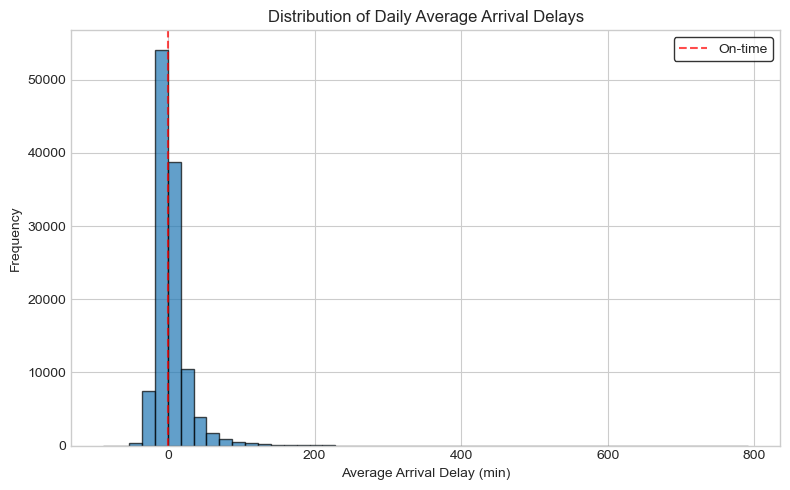

In [5]:
# histogram of arrival delay distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['avg_arr_delay'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Average Arrival Delay (min)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Daily Average Arrival Delays')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='On-time')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

The delay distribution is pretty right-skewed. Most days have small delays or even early arrivals (negative values), but there is a long tail of bad delay days. 

## Daily Average Delays Over Time

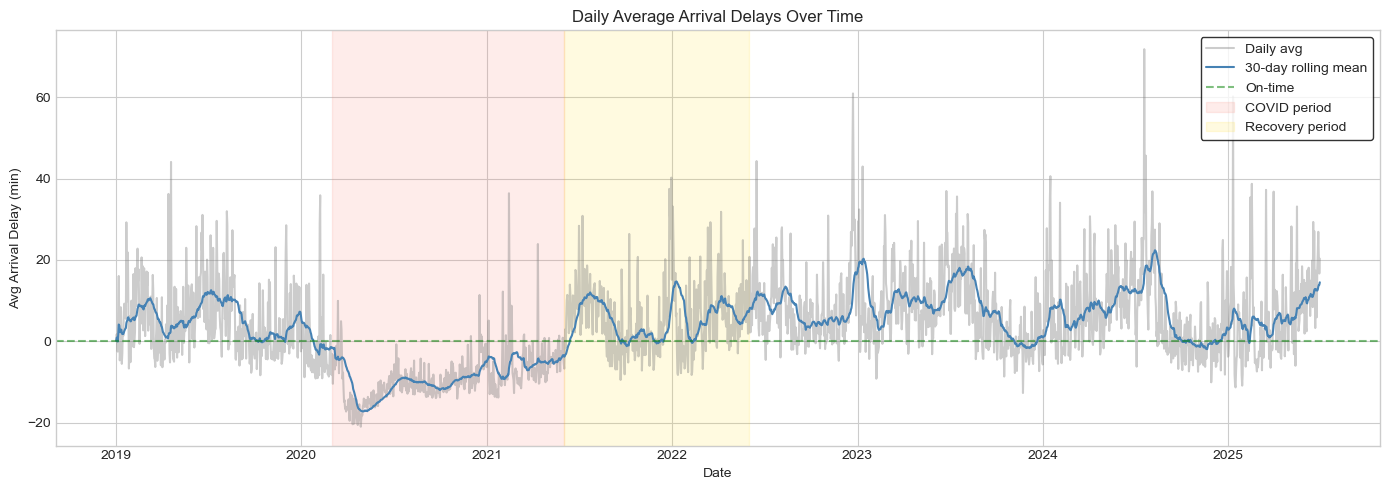

In [6]:
# time series of daily average delays with COVID period highlighted
daily_delay = df.groupby('date')['avg_arr_delay'].mean().reset_index()
daily_delay['rolling_30'] = daily_delay['avg_arr_delay'].rolling(30, min_periods=1).mean()

covid_start = pd.Timestamp('2020-03-01')
covid_end = pd.Timestamp('2021-06-01')
recovery_end = pd.Timestamp('2022-06-01')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_delay['date'], daily_delay['avg_arr_delay'], color='gray', alpha=0.4, label='Daily avg')
ax.plot(daily_delay['date'], daily_delay['rolling_30'], color='steelblue', label='30-day rolling mean')
ax.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='On-time')
ax.axvspan(covid_start, covid_end, color='salmon', alpha=0.15, label='COVID period')
ax.axvspan(covid_end, recovery_end, color='gold', alpha=0.12, label='Recovery period')
ax.set_title('Daily Average Arrival Delays Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Arrival Delay (min)')
ax.legend(loc='upper right', frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

Interesting pattern here, the delays dropped dramatically during COVID (early 2020) when there were way fewer flights. Then they spiked up during the recovery period in 2021-2022. It appears that those patterns have stabilized/returned to their typical form since then.

## Weekly and Monthly Delay Patterns

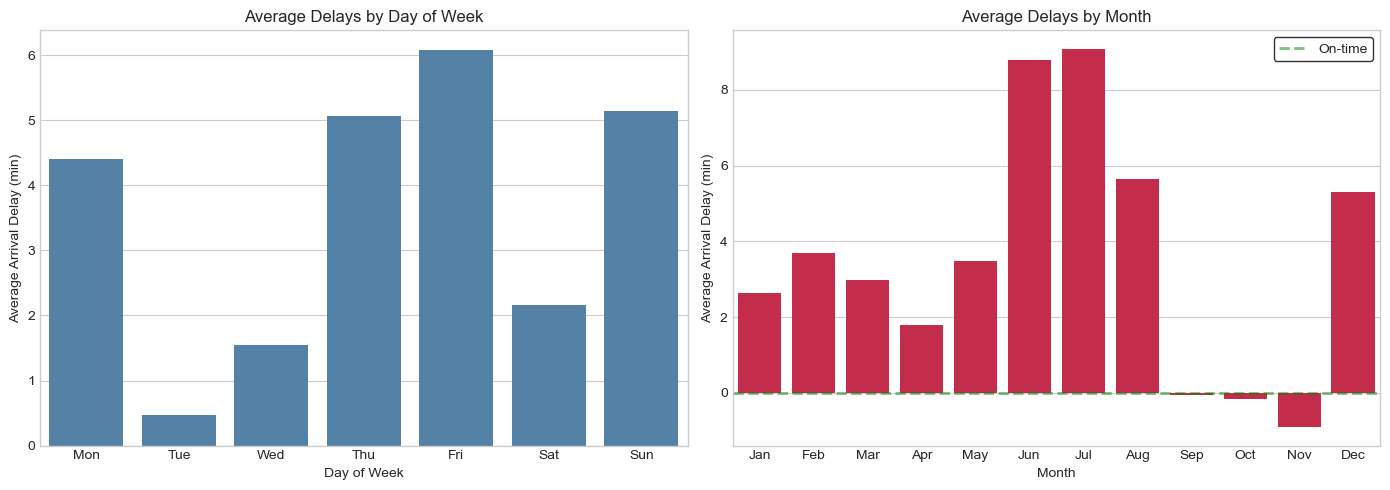

In [7]:
# average delays by day of week and month
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

dow_avg = df.groupby('day_of_week')['avg_arr_delay'].mean().reset_index()
dow_avg['day_name'] = dow_avg['day_of_week'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

sns.barplot(data=dow_avg, x='day_name', y='avg_arr_delay', color='steelblue', ax=ax1)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Average Arrival Delay (min)')
ax1.set_title('Average Delays by Day of Week')

month_avg = df.groupby('month')['avg_arr_delay'].mean().reset_index()
month_avg['month_name'] = month_avg['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

sns.barplot(data=month_avg, x='month_name', y='avg_arr_delay', color='crimson', ax=ax2)
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Arrival Delay (min)')
ax2.set_title('Average Delays by Month')
ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='On-time', linewidth=2)
ax2.legend(frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

Thursday, Friday and Sunday have the worst delays, which lines up with weekend travel patterns. Monthly patterns show summer months (June-August) have higher delays, likely due to peak vacation travel volume. December also stands out, probably from holiday travel.

## Routes by Average Delay

/var/folders/vw/c11105x93rdfqx32_1qmzfn40000gn/T/ipykernel_16926/2670896265.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=route_df, y='route', x='avg_arr_delay', palette=colors, ax=ax)


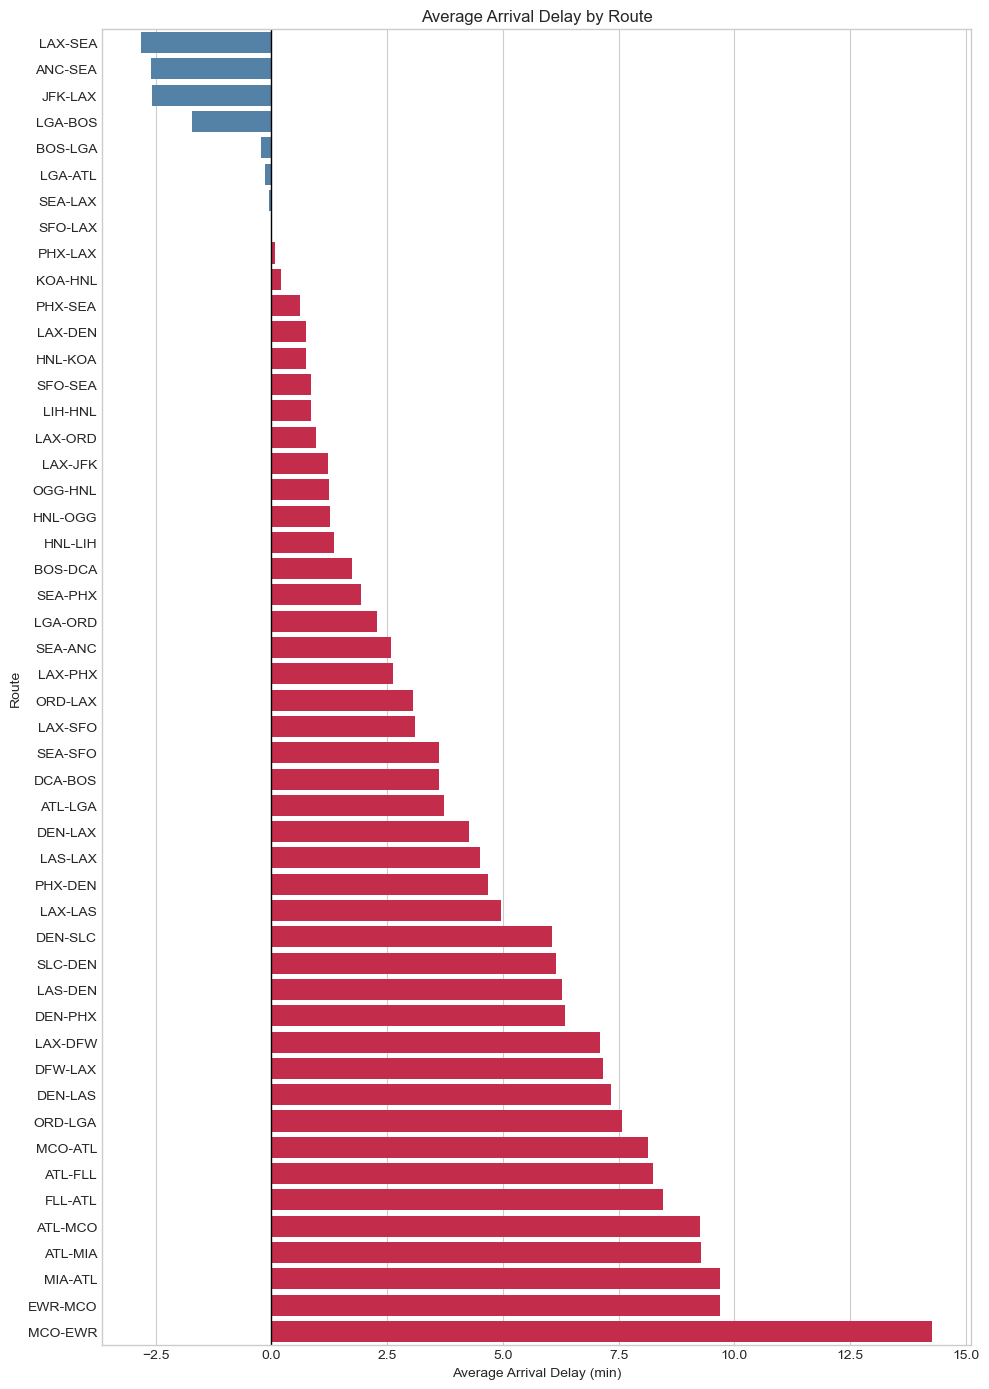

In [8]:
# horizontal bar chart of average delay by route
route_delays = df.groupby('route')['avg_arr_delay'].mean().sort_values(ascending=True)
route_df = route_delays.reset_index()

fig, ax = plt.subplots(figsize=(10, 14))
colors = ['steelblue' if x < 0 else 'crimson' for x in route_df['avg_arr_delay']]
sns.barplot(data=route_df, y='route', x='avg_arr_delay', palette=colors, ax=ax)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_title('Average Arrival Delay by Route')
ax.set_xlabel('Average Arrival Delay (min)')
ax.set_ylabel('Route')
plt.tight_layout()
plt.show()

## Delay Autocorrelation

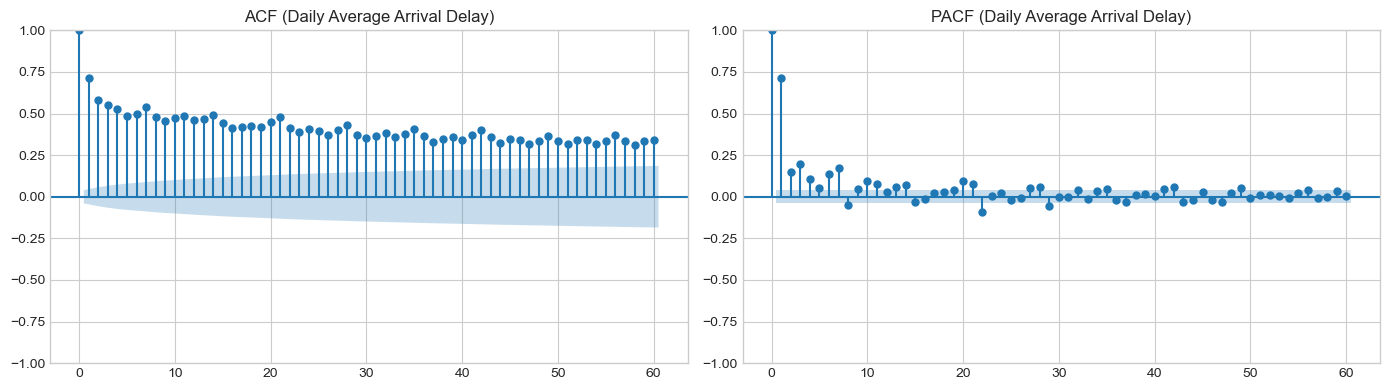

In [9]:
# autocorrelation and partial autocorrelation plots
daily_delay_ts = df.groupby('date')['avg_arr_delay'].mean()
series = daily_delay_ts.asfreq('D').fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(series, lags=60, ax=ax1)
plot_pacf(series, lags=60, ax=ax2)
ax1.set_title('ACF (Daily Average Arrival Delay)')
ax2.set_title('PACF (Daily Average Arrival Delay)')
plt.tight_layout()
plt.show()

## Route Delay Summary Stats

In [10]:
# summary statistics by route
route_stats = df.groupby('route').agg({
    'avg_arr_delay': ['mean', 'std', 'min', 'max']
}).round(2)
route_stats.columns = ['Mean (min)', 'Std', 'Min', 'Max']
route_stats = route_stats.sort_values('Mean (min)', ascending=False)
route_stats

,Mean (min),Std,Min,Max
route,,,,
MCO-EWR,14.26,30.98,-55.00,271.27
EWR-MCO,9.70,28.11,-59.50,171.62
MIA-ATL,9.69,28.18,-21.57,429.50
ATL-MIA,9.28,27.12,-25.25,594.75
ATL-MCO,9.26,23.19,-21.64,326.50
FLL-ATL,8.45,24.03,-26.33,310.55
ATL-FLL,8.24,22.26,-22.25,409.67
MCO-ATL,8.12,25.20,-27.38,288.57
ORD-LGA,7.57,30.01,-41.00,370.44


## Weather Impact on Delays

Weather data from Open-Meteo has been merged with the flight data by matching airport codes. For each route, `apt1_*` columns contain weather at the origin airport and `apt2_*` columns contain weather at the destination. The `weather_severity_max` column takes the worse of the two.

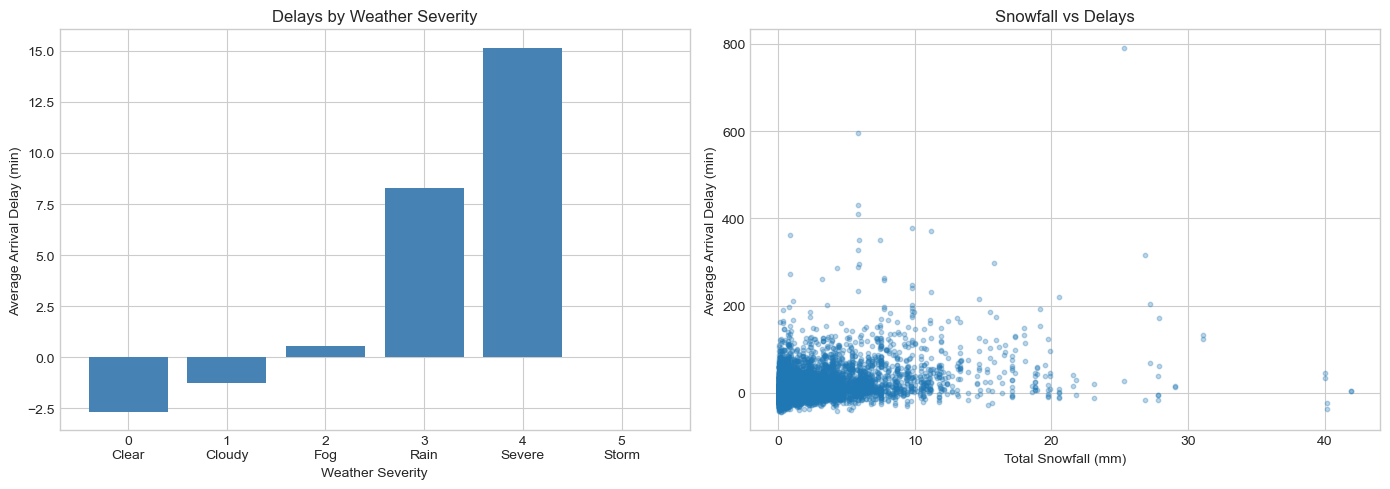

In [11]:
# delays by weather severity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

severity_delays = df.groupby('weather_severity_max')['avg_arr_delay'].mean()
all_severities = range(6)
delay_values = [severity_delays.get(s, 0) for s in all_severities]

bars = ax1.bar(all_severities, delay_values, color='steelblue')

ax1.set_xlabel('Weather Severity')
ax1.set_ylabel('Average Arrival Delay (min)')
ax1.set_title('Delays by Weather Severity')

severity_labels = ['0\nClear', '1\nCloudy', '2\nFog', '3\nRain', '4\nSevere', '5\nStorm']
ax1.set_xticks(all_severities)
ax1.set_xticklabels(severity_labels)

# scatter of snowfall vs delay
snow_days = df[df['total_snowfall'] > 0]
ax2.scatter(snow_days['total_snowfall'], snow_days['avg_arr_delay'], alpha=0.3, s=10)
ax2.set_xlabel('Total Snowfall (mm)')
ax2.set_ylabel('Average Arrival Delay (min)')
ax2.set_title('Snowfall vs Delays')

plt.tight_layout()
plt.show()

Severity 5 (thunderstorm) barely shows up in the daily codes because thunderstorms don't last all day. The hourly features (`storm_hours`, `max_hourly_severity`) catch them better.

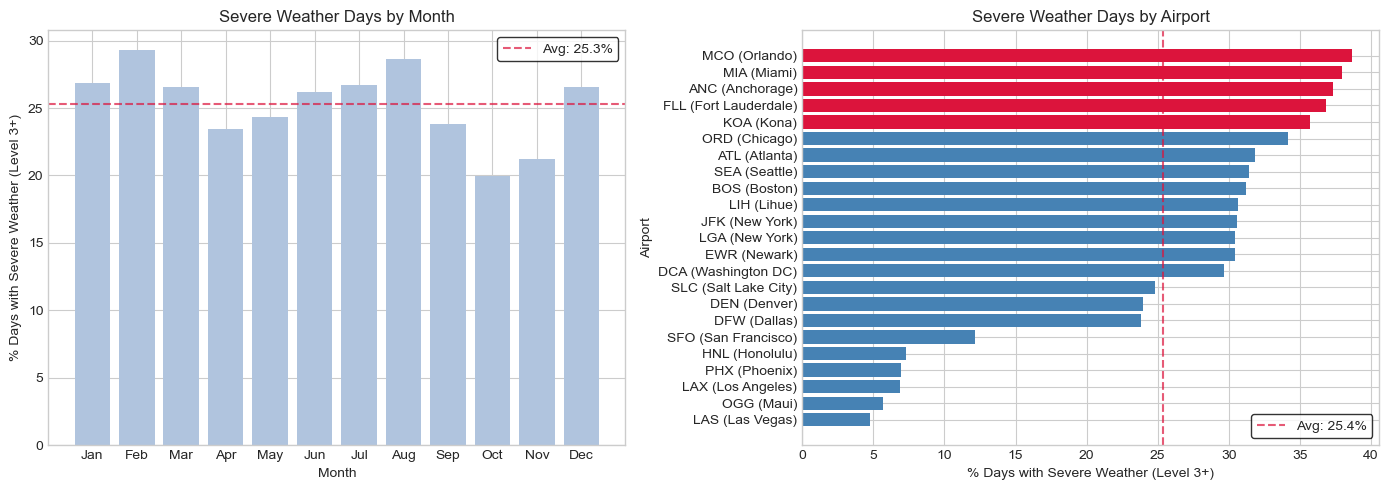


Key observations:
  Winter months (Dec-Feb) average 27.6% severe weather days
  Summer months (Jun-Aug) average 27.2% severe weather days


In [12]:
# Weather patterns by month and by airport
# Load weather data directly to analyze patterns independent of routes
weather_df = pd.read_csv('../data/weather/weather_daily.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['month'] = weather_df['date'].dt.month

# airport code to city mapping
airport_cities = {
    'MCO': 'MCO (Orlando)',
    'FLL': 'FLL (Fort Lauderdale)',
    'ORD': 'ORD (Chicago)',
    'ATL': 'ATL (Atlanta)',
    'BOS': 'BOS (Boston)',
    'JFK': 'JFK (New York)',
    'LGA': 'LGA (New York)',
    'DCA': 'DCA (Washington DC)',
    'DEN': 'DEN (Denver)',
    'SFO': 'SFO (San Francisco)',
    'HNL': 'HNL (Honolulu)',
    'PHX': 'PHX (Phoenix)',
    'LAX': 'LAX (Los Angeles)',
    'OGG': 'OGG (Maui)',
    'LAS': 'LAS (Las Vegas)',
    'DFW': 'DFW (Dallas)',
    'EWR': 'EWR (Newark)',
    'MIA': 'MIA (Miami)',
    'SEA': 'SEA (Seattle)',
    'SLC': 'SLC (Salt Lake City)',
    'ANC': 'ANC (Anchorage)',
    'KOA': 'KOA (Kona)',
    'LIH': 'LIH (Lihue)'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Monthly distribution of severe weather days (severity >= 3)
monthly_severe = weather_df[weather_df['severity'] >= 3].groupby('month').size()
monthly_total = weather_df.groupby('month').size()
monthly_severe_pct = (monthly_severe / monthly_total * 100).fillna(0)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['steelblue' if pct >= 30 else 'lightsteelblue' for pct in monthly_severe_pct.values]

ax1.bar(range(1, 13), monthly_severe_pct.values, color=colors)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names)
ax1.set_xlabel('Month')
ax1.set_ylabel('% Days with Severe Weather (Level 3+)')
ax1.set_title('Severe Weather Days by Month')
ax1.axhline(y=monthly_severe_pct.mean(), color='crimson', linestyle='--', alpha=0.7, label=f'Avg: {monthly_severe_pct.mean():.1f}%')
ax1.legend(frameon=True, edgecolor='black')

# Severe weather by airport
airport_severe = weather_df[weather_df['severity'] >= 3].groupby('airport').size()
airport_total = weather_df.groupby('airport').size()
airport_severe_pct = (airport_severe / airport_total * 100).fillna(0).sort_values(ascending=True)

# map airport codes to include city names
airport_labels = [airport_cities.get(apt, apt) for apt in airport_severe_pct.index]

colors_apt = ['crimson' if pct >= 35 else 'steelblue' for pct in airport_severe_pct.values]
ax2.barh(airport_labels, airport_severe_pct.values, color=colors_apt)
ax2.set_xlabel('% Days with Severe Weather (Level 3+)')
ax2.set_ylabel('Airport')
ax2.set_title('Severe Weather Days by Airport')
ax2.axvline(x=airport_severe_pct.mean(), color='crimson', linestyle='--', alpha=0.7, label=f'Avg: {airport_severe_pct.mean():.1f}%')
ax2.legend(frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

print(f"\nKey observations:")
print(f"  Winter months (Dec-Feb) average {monthly_severe_pct[[12, 1, 2]].mean():.1f}% severe weather days")
print(f"  Summer months (Jun-Aug) average {monthly_severe_pct[[6, 7, 8]].mean():.1f}% severe weather days")

**Weather Seasonality Findings:**

Winter and summer months have similar rates of severe weather days (around 24-25%). Makes sense when you consider that summer brings thunderstorms and rain while winter brings snow and freezing precipitation.

The similar severe weather rates across seasons, combined with higher summer delays, reinforces that **summer delays are driven by travel volume** rather than weather alone.

**Geographic Patterns:**

Florida airports (MCO, FLL) have the highest severe weather rates from frequent summer thunderstorms. Midwest hubs (ORD, ATL) also show elevated rates. Western airports (LAX, LAS, PHX, SFO) and Hawaii (HNL, OGG) have the lowest, which tracks with their drier climates.

Since each route already has origin/destination weather, the model picks up on these geographic differences naturally.

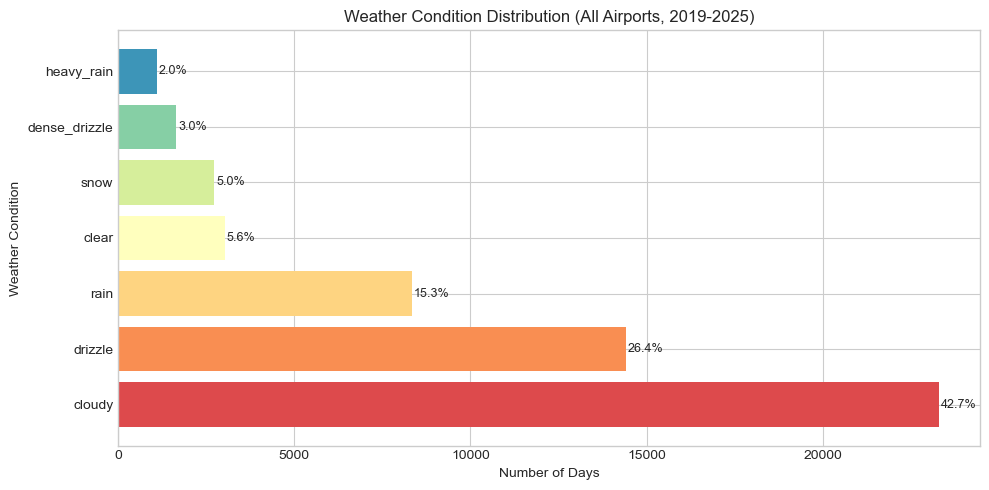

In [13]:
condition_counts = weather_df['condition'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))

# seaborn color palette 
palette = sns.color_palette('Spectral', n_colors=len(condition_counts))
ax.barh(condition_counts.index, condition_counts.values, color=palette)
ax.set_xlabel('Number of Days')
ax.set_ylabel('Weather Condition')
ax.set_title('Weather Condition Distribution (All Airports, 2019-2025)')

# Add percentages
total = condition_counts.sum()
for i, (cond, count) in enumerate(condition_counts.items()):
    pct = count / total * 100
    ax.text(count + 50, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Most days have mild weather conditions. Cloudy days are most common (47%), followed by drizzle (24%) and rain (14%). Severe conditions like snow (3.7%), heavy rain (2.1%), and dense drizzle (2.2%) are pretty rare, so the model won't have many examples to learn from.

## Feature Correlations

How different features correlate with arrival delays.

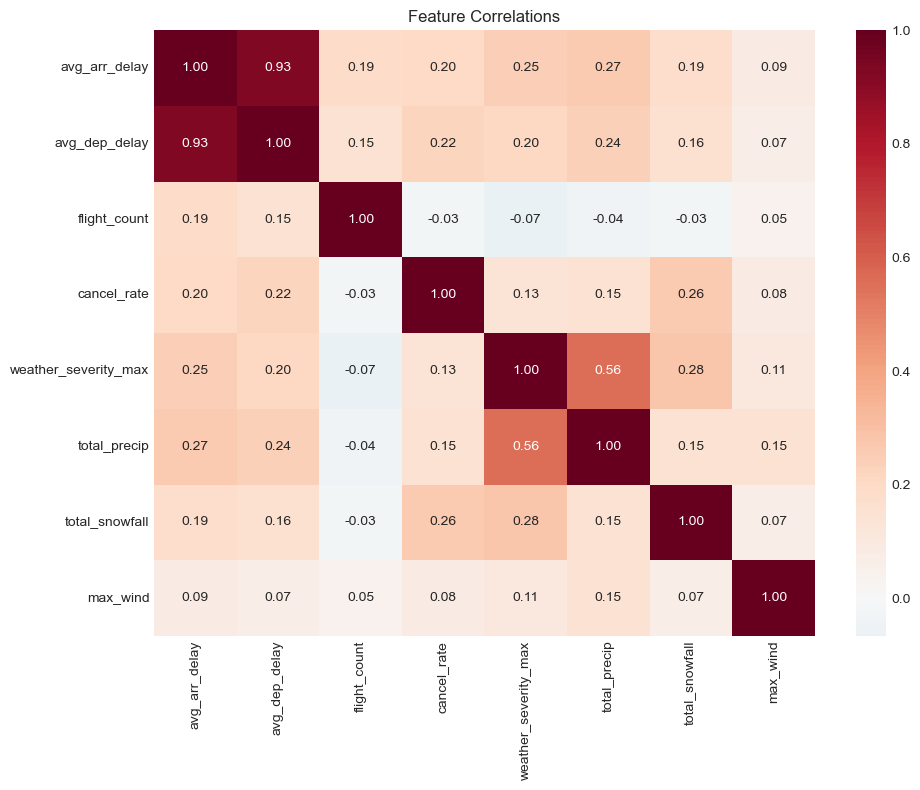


Correlations with avg_arr_delay:
avg_dep_delay           0.928041
total_precip            0.266159
weather_severity_max    0.247531
cancel_rate             0.204235
flight_count            0.193840
total_snowfall          0.185983
max_wind                0.085039
Name: avg_arr_delay, dtype: float64


In [14]:
# correlation heatmap for numeric features
numeric_cols = ['avg_arr_delay', 'avg_dep_delay', 'flight_count', 'cancel_rate',
                'weather_severity_max', 'total_precip', 'total_snowfall', 'max_wind']
numeric_cols = [c for c in numeric_cols if c in df.columns]

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=ax)
ax.set_title('Feature Correlations')
plt.tight_layout()
plt.show()

print("\nCorrelations with avg_arr_delay:")
delay_corrs = corr_matrix['avg_arr_delay'].drop('avg_arr_delay').sort_values(ascending=False)
print(delay_corrs)

Departure delay is highly correlated with arrival delay (0.93), which seems pretty obvious, since late departures usually mean late arrivals. Weather severity and snowfall show positive correlations with delays, confirming what we saw in the charts above.

## Key Takeaways

- Delays are right-skewed with a long tail of really bad days
- Day of week and month both matter (Fridays, Sundays, summer months are worst)
- COVID created a discontinuity that'll need period flags
- Weather is predictive (severity, snowfall, precipitation all correlate with delays), but summer delays are more volume-driven than weather-driven since winter and summer have similar severe weather rates (~24-25%)
- Florida and Midwest hubs get the most severe weather, West Coast and Hawaii the least
- ACF shows autocorrelation, so lag features should help

**Next:** [02_feature_engineering.ipynb](02_feature_engineering.ipynb) builds these features.